In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
plt.plot([0, 1], [0, 1])

In [3]:


import itertools
import numpy as np
import torch
import torch.jit
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import sklearn.decomposition
import sklearn.manifold
import sklearn.neighbors
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import polars as pl
import scipy.stats
from mpl_toolkits.axes_grid1 import ImageGrid
import torchinfo


In [28]:
# sim_dir = "/groups/saalfeld/home/allierc/Py/NeuralGraph/graphs_data/fly/fly_N9_54_1"
# use local copy - faster
sim_dir = "/mnt/localdata/fly_N9_54_1"

In [29]:
from NeuralGraph.generators.load_flyvis import SimulationResults, FlyVisSim


sim_results = SimulationResults.load(f"{sim_dir}/x_list_0.npy")

In [7]:
neuron_types = sim_results[FlyVisSim.TYPE][0]
index_to_name = {0: 'Am', 1: 'C2', 2: 'C3', 3: 'CT1(Lo1)', 4: 'CT1(M10)', 5: 'L1', 6: 'L2',
    7: 'L3', 8: 'L4', 9: 'L5', 10: 'Lawf1', 11: 'Lawf2', 12: 'Mi1', 13: 'Mi10',
    14: 'Mi11', 15: 'Mi12', 16: 'Mi13', 17: 'Mi14', 18: 'Mi15', 19: 'Mi2',
    20: 'Mi3', 21: 'Mi4', 22: 'Mi9', 23: 'R1', 24: 'R2', 25: 'R3', 26: 'R4',
    27: 'R5', 28: 'R6', 29: 'R7', 30: 'R8', 31: 'T1', 32: 'T2', 33: 'T2a',
    34: 'T3', 35: 'T4a', 36: 'T4b', 37: 'T4c', 38: 'T4d', 39: 'T5a', 40: 'T5b',
    41: 'T5c', 42: 'T5d', 43: 'Tm1', 44: 'Tm16', 45: 'Tm2', 46: 'Tm20', 47: 'Tm28',
    48: 'Tm3', 49: 'Tm30', 50: 'Tm4', 51: 'Tm5Y', 52: 'Tm5a', 53: 'Tm5b',
    54: 'Tm5c', 55: 'Tm9', 56: 'TmY10', 57: 'TmY13', 58: 'TmY14', 59: 'TmY15',
    60: 'TmY18', 61: 'TmY3', 62: 'TmY4', 63: 'TmY5a', 64: 'TmY9'
}
neuron_type_name = [
    "Am", "C2", "C3", "CT1(Lo1)", "CT1(M10)",
    "L1", "L2", "L3", "L4", "L5", "Lawf1", "Lawf2",
    "Mi1", "Mi10", "Mi11", "Mi12", "Mi13", "Mi14", "Mi15", "Mi2", "Mi3", "Mi4", "Mi9",
    "R1", "R2", "R3", "R4", "R5", "R6", "R7", "R8",
    "T1", "T2", "T2a", "T3", "T4a", "T4b", "T4c", "T4d", "T5a", "T5b", "T5c", "T5d",
    "Tm1", "Tm16", "Tm2", "Tm20", "Tm28", "Tm3", "Tm30", "Tm4", "Tm5Y",
    "Tm5a", "Tm5b", "Tm5c", "Tm9", "TmY10", "TmY13", "TmY14",
    "TmY15", "TmY18", "TmY3", "TmY4", "TmY5a", "TmY9"
]
neuron_type_index = {t: i for i, t in enumerate(neuron_type_name)}

def compute_ixs_per_type(neuron_types):
    """Compute indices corresponding to each neuron type."""
    order = np.argsort(neuron_types)
    uniq_types, start_index = np.unique(neuron_types[order], return_index=True)
    num_neuron_types = len(uniq_types)
    assert (uniq_types == np.arange(num_neuron_types)).all(), "breaks assumptions"
    breaks = np.zeros(len(uniq_types)+1, dtype=np.int64)
    breaks[:-1] = start_index
    breaks[-1] = len(neuron_types)
    return [
        order[breaks[i]:breaks[i+1]] for i in range(num_neuron_types)
    ]
neuron_ixs_by_type = compute_ixs_per_type(neuron_types)


## Analyze runs

In [23]:
import glob
import yaml

run_dirs = glob.glob("/home/kumarv4@hhmi.org/repos/NeuralGraph/runs/*")
concat = []
for run_dir in run_dirs:
    df = pl.read_csv(f"{run_dir}/training_log.csv")
    config = yaml.safe_load(open(f"{run_dir}/config.yaml"))
    concat.append(
        df.with_columns(
            batch_size=pl.lit(config["training"]["batch_size"]),
            run_dir=pl.lit(run_dir),
        )
    )
concat = pl.concat(concat).sort("batch_size", "epoch")

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
for (batch_size,), df in concat.group_by("batch_size", maintain_order=True):
    ax[0].plot(df["train_loss"], label=f"{batch_size=}")
    ax[1].plot(df["val_loss"], label=f"{batch_size=}")
ax[0].legend()
ax[1].legend()
ax[0].set_yscale("log")

## Load a model and investigate

In [51]:
best_run_dir = concat.tail(1)["run_dir"].to_list()[0]

In [52]:
from NeuralGraph.models.latent import LatentModel, ModelParams

In [53]:
device = torch.device("cuda")

In [54]:
cfg = ModelParams(**yaml.safe_load(open(f"{best_run_dir}/config.yaml")))
model = LatentModel(cfg).to(device)
model.load_state_dict(torch.load(f"{best_run_dir}/model_final.pt", weights_only=False))

<All keys matched successfully>

In [61]:
with torch.no_grad():
    activity = torch.tensor(sim_results[FlyVisSim[cfg.training.column_to_model]], device=device)

In [84]:
split = cfg.training.data_split
train_mat = activity[split.train_start:split.train_end]
train_res = model(train_mat).detach().cpu().numpy()

In [81]:
recon = model.decoder(model.encoder(train_mat)).detach().cpu().numpy()

In [ ]:
neuron = np.random.choice(13741)
neuron=8767
print(f"{neuron=}")
v = train_mat[:, neuron].detach().cpu().numpy()
vr = train_res[:, neuron]
i = np.argmax(np.abs(np.diff(v)))

plt.figure(figsize=(3, 2))
plt.plot(v, lw=2, alpha=0.3)
plt.plot(vr)
plt.xlim(10000, 10100)

In [138]:
from scipy.ndimage import gaussian_filter1d

# Stimulus is only provided to the first 1736 neurons and we hard-code that there

# We pre-filter before downsampling to avoid any aliasing
stimulus = gaussian_filter1d(x[BURNIN_OFFSET:, :1736, STIMULUS_COLUMN], sigma=OBS_TIME_STEPS / 2)[
    ::OBS_TIME_STEPS
] if OBS_TIME_STEPS > 1 else x[BURNIN_OFFSET:, :1736, STIMULUS_COLUMN].copy()
stimulus.shape

(88720, 1736)

In [140]:
device = torch.device("cuda")

train_tensor = torch.concatenate(
    [
        torch.tensor(train_mat, device=device),
        torch.tensor(stimulus[train_start:train_end], device=device),
    ],
    dim=1,
)
train_tensor.shape

torch.Size([17744, 15477])

In [141]:
# use tf32 math for speed - but perhaps we are sacrificing accuracy in roll out
torch.set_float32_matmul_precision('high')

In [147]:
class MLP(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            torch.nn.init.normal_(linear.weight, mean=0.0, std=0.01)
            torch.nn.init.zeros_(linear.bias)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))

    def forward(self, x):
        y = self.layers[0](x)
        for layer in self.layers[1:-1]:
            y = layer(y)
        return self.layers[-1](y)

class MLPWithResidual(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            torch.nn.init.normal_(linear.weight, mean=0.0, std=0.01)
            torch.nn.init.zeros_(linear.bias)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))

    def forward(self, x):
        y = self.layers[0](x)
        for layer in self.layers[1:-1]:
            y = y + layer(y)
        return self.layers[-1](y)



class MLPWithLinear(torch.nn.Module):
    def __init__(
        self,
        num_input_dims: int,
        num_output_dims: int,
        num_hidden_layers: int,
        num_hidden_units: int,
    ):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        input_dims = num_input_dims
        for i in range(num_hidden_layers):
            linear = torch.nn.Linear(input_dims, num_hidden_units)
            self.layers.append(linear)
            self.layers.append(torch.nn.Tanh())
            input_dims = num_hidden_units
        self.layers.append(torch.nn.Linear(num_hidden_units, num_output_dims))
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.normal_(layer.weight, mean=0.0, std=0.01)
                torch.nn.init.zeros_(layer.bias)
        self.linear_layer = torch.nn.Linear(num_input_dims, num_output_dims)

    def forward(self, x):
        y = self.layers[0](x)
        for layer in self.layers[1:-1]:
            y = layer(y)

        return self.layers[-1](y) + self.linear_layer(x)


class Encoder(torch.nn.Module):
    def __init__(self, **mlp_kwargs):
        super().__init__()
        self.mlp = MLPWithResidual(**mlp_kwargs)
        # self.linear = torch.nn.Linear(mlp_kwargs["num_input_dims"], mlp_kwargs["num_output_dims"])


    def forward(self, x):
        return self.mlp(x) #+ self.linear(x)


class Evolver(torch.nn.Module):
    def __init__(self, time_units: int, **mlp_kwargs):
        super().__init__()
        self.time_units = time_units
        self.evolver = MLPWithResidual(**mlp_kwargs)

    def forward(self, x):
        for _ in range(self.time_units):
            x = x + self.evolver(x)
        return x


class Decoder(torch.nn.Module):
    def __init__(self, **mlp_kwargs):
        super().__init__()
        self.mlp = MLPWithResidual(**mlp_kwargs)
        # self.linear = torch.nn.Linear(mlp_kwargs["num_input_dims"], mlp_kwargs["num_output_dims"])


    def forward(self, x):
        return self.mlp(x) #+ self.linear(x)

In [288]:

L = 512
# MAX_VALUE = 2.0
encoder = Encoder(
    # max_value=MAX_VALUE,
    num_input_dims=train_tensor.shape[1],
    num_output_dims=L,
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()

decoder = Decoder(
    # max_value=MAX_VALUE,
    num_input_dims=L,
    num_output_dims=train_mat.shape[1],
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()
evolver = Evolver(
    time_units=OBS_TIME_STEPS,
    # max_value=MAX_VALUE,
    num_input_dims=L,
    num_output_dims=L,
    num_hidden_layers=3,
    num_hidden_units=L,
).cuda()


# train_with_evolution_opt = torch.compile(train_with_evolution, fullgraph=True, mode="reduce-overhead")


In [316]:

a = [1]
a[1:-1]

[]

In [289]:

@torch.compile(fullgraph=True, mode="reduce-overhead")
def train_with_evolution(encoder, decoder, evolver, train_tensor, rollout=1):

    proj = encoder(train_tensor)
    recon = decoder(proj)

    # remove stimulus piece at the end
    activity = train_tensor[:, :-1736]

    # reconstruction loss
    recon_loss = torch.nn.MSELoss()(activity, recon)

    for _ in range(rollout):
        proj = evolver(proj)
    recon1 = decoder(proj)
    # time steps are nearby
    evolve_loss = torch.nn.MSELoss()(recon1[:-rollout], activity[rollout:])
    # evolve_loss = torch.tensor(0.0)

    # proj = evolver(proj)
    # recon2 = decoder(proj)
    # # time steps are nearby
    # evolve_loss += torch.nn.MSELoss()(recon2[:-2], activity[2:])

    return evolve_loss, recon_loss

In [290]:

# # First train encoder/decoder
# opt = torch.optim.Adam(
#     list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
#     lr=1e-3,
# )
# loop = tqdm.trange(10000, ncols=120)
# for i in loop:
#     opt.zero_grad(True)

#     loss = train_encoded_rep(encoder, decoder, evolver, train_tensor)
#     loop.set_postfix(
#         # recon=recon_loss.item(),
#         recon_loss=loss.item(),
#         # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
#     )
#     loss.backward()
#     opt.step()

# now train with the evolver
# First train encoder/decoder
opt = torch.optim.Adam(
    list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
    lr=1e-4,
)
# scheduler1 = torch.optim.lr_scheduler.MultiStepLR(
#     opt, milestones=[10000,], gamma=0.1,
# )
# scheduler2 = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     opt, T_0=100, T_mult=2, eta_min=1e-6
# )
# scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[1000, 10_000], gamma=0.1)
loop = tqdm.trange(100_000, ncols=120)
for i in loop:
    opt.zero_grad()

    evolve_loss, recon_loss = train_with_evolution(encoder, decoder, evolver, train_tensor)
    loss = evolve_loss + recon_loss
    loop.set_postfix(
        recon=recon_loss.item(),
        evolve_loss=evolve_loss.item(),
        # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
    )

    loss.backward()
    opt.step()
    # scheduler1.step()
    # scheduler2.step()

100%|██████████████████████████████████████| 100000/100000 [2:23:52<00:00, 11.58it/s, evolve_loss=0.0032, recon=0.00304]


In [308]:
train_tensor.shape

torch.Size([17744, 15477])

In [291]:
# opt = torch.optim.Adam(
#     list(itertools.chain(encoder.parameters(), decoder.parameters(), evolver.parameters())),
#     lr=1e-4,
# )
# loop = tqdm.trange(10000, ncols=120)
# for i in loop:
#     opt.zero_grad(True)

#     loss, recon_loss = train_with_evolution(encoder, decoder, evolver, train_tensor)
#     loop.set_postfix(
#         recon=recon_loss.item(),
#         loss=loss.item(),
#         # lr=f"{scheduler1.get_last_lr()[0]:.3e}"
#     )

#     loss.backward()
#     opt.step()

In [292]:
# Save models
# ep = torch.export.export(encoder, (train_tensor,))
# torch.export.save(ep, "/mnt/localdata/encoder.pt2")
# proj = encoder(train_tensor)
# ep = torch.export.export(decoder, (proj,))
# torch.export.save(ep, "/mnt/localdata/decoder.pt2")
# ep = torch.export.export(evolver, (proj,))
# torch.export.save(ep, "/mnt/localdata/evolver.pt2")

In [293]:
val_tensor = torch.concatenate(
    [
        torch.tensor(val_mat, device=device),
        torch.tensor(stimulus[validation_start:validation_end], device=device),
    ],
    dim=1,
)

In [294]:
proj = encoder(val_tensor)
recon = decoder(proj)

proj1 = proj.detach().cpu().numpy()
recon1 = recon.detach().cpu().numpy()

In [295]:
with torch.no_grad():
    x0 = encoder(val_tensor[:1, :])
    results = [x0]
    for _ in range((val_tensor.shape[0] - 1)):
        prev = results[-1]
        state = prev.detach().clone()
        state = evolver(state)
        results.append(state)
    final = decoder(torch.cat(results, dim=0))
    final1 = final.detach().cpu().numpy()

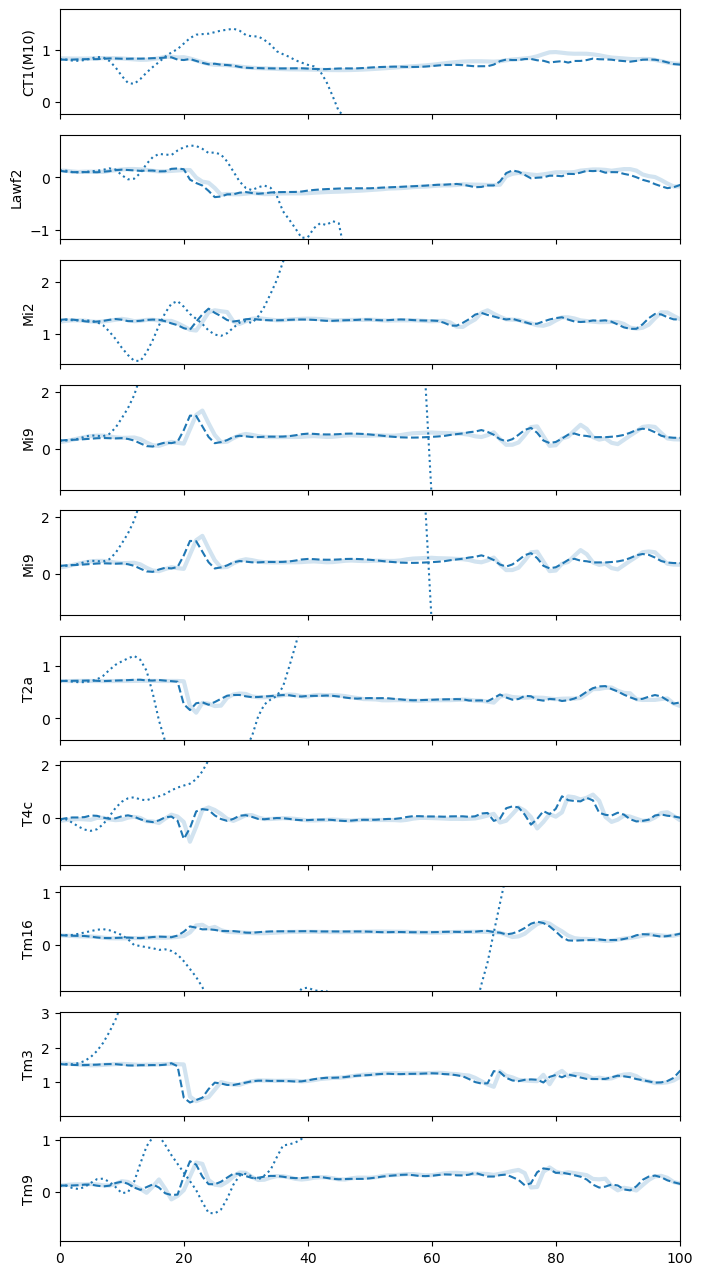

In [307]:

plot_neuron_types = np.sort(np.random.choice(neuron_type_name, 10))
# ['R1', 'R7', 'C2', 'Mi11', 'Tm1', 'Tm4', 'Tm30']

_, ax = plt.subplots(len(plot_neuron_types), 1, figsize=(8, 16), sharex=True)
t0 = 0
T = val_mat.shape[0]
tvals = np.arange(t0, t0 + T)
rng = np.random.default_rng(seed=123)
picks = [rng.choice(nixs) for nixs in neuron_ixs_by_type]

for i, ptype in enumerate(plot_neuron_types):
    nix = picks[neuron_type_index[ptype]]
    true_trace = val_mat[:, nix]
    p = ax[i].plot(
        tvals,
        recon1[:, nix],
        ls="dashed",
        # marker=".",
        label="reconstruct each time point",
    )

    ax[i].plot(tvals, true_trace, lw=3, color=p[-1].get_color(), alpha=0.2)
    ylim = ax[i].get_ylim()
    yc = 0.5*(ylim[0] + ylim[1])
    ylen = ylim[1] - ylim[0]
    if ylen < 2:
        ylim = (yc-1, yc+1)


    # ax[i].set_ylim(1, 2)
    # time evolve
    ax[i].plot(
        tvals,
        final1[:, nix],
        color=p[-1].get_color(),
        ls="dotted",
        label="learn linear evolver",
    )


    ax[i].set_ylim(*ylim)
    ax[i].set_ylabel(ptype)
plt.xlim(0, 100)
plt.subplots_adjust(hspace=0.2)

In [297]:
delta = (val_mat - final1).astype(np.float64)
val_mat_shuffle = val_mat.copy()
rng = np.random.default_rng(seed=0)
rng.shuffle(val_mat_shuffle, axis=0)
delta_shuffle = val_mat_shuffle - val_mat

delta_constant = val_mat - val_mat[:1]

Text(0.5, 0, 'Time')

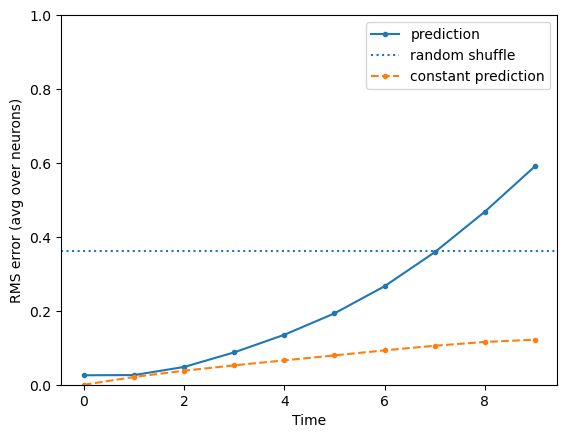

In [298]:
rms_shuffle = np.sqrt(np.power(delta_shuffle, 2).mean(axis=1))
rms_pred =np.sqrt(np.power(delta, 2).mean(axis=1))
rms_constant =np.sqrt(np.power(delta_constant, 2).mean(axis=1))
plt.plot(rms_pred[:10], marker=".", label="prediction")

plt.axhline(rms_shuffle.mean(), ls="dotted", label="random shuffle")
plt.plot(rms_constant[:10], ls="dashed", marker=".", label="constant prediction")
# plt.yscale("log")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("RMS error (avg over neurons)")
plt.xlabel("Time")

In [299]:
proj1 = evolver(proj)
recon1 = decoder(proj1).detach().cpu().numpy()
dx_true = val_mat[1:] - val_mat[:-1]
dx_pred = recon1[:-1] - val_mat[:-1]
err = dx_pred - dx_true

In [300]:
# npts = 500
# rng = np.random.default_rng(seed=0)
# t0s = np.sort(rng.choice(val_tensor.shape[0], replace=False, size=npts))
# x0 = val_mat[t0s, :]
# proj_x0 = proj[t0s, :]
# x1_pred = decoder(evolver(proj_x0)).detach().cpu().numpy()
# x1_true = val_mat[t0s+1, :]

In [301]:
# dx_pred = x1_pred - x0
# dx_true = x1_true - x0


In [302]:
bins = np.linspace(-0.5, 0.5, 101)
mps = 0.5*(bins[1:] + bins[:-1])
den, _ = np.histogram(dx_true, bins=bins)
num, _ = np.histogram(dx_true, bins=bins, weights=np.abs(err))

Text(0.5, 0, 'v(t+1) - v(t) true')

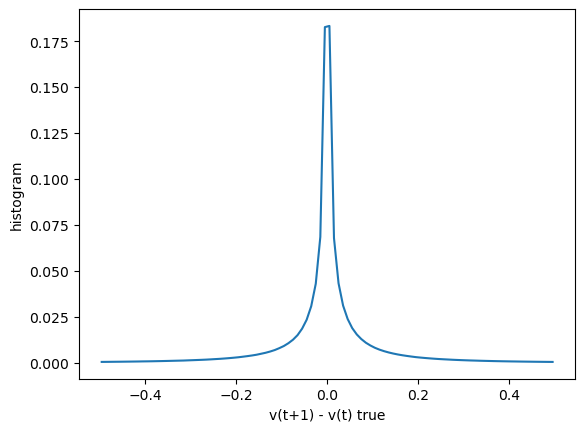

In [303]:
plt.plot(mps, den / den.sum())
plt.ylabel("histogram")
plt.xlabel("v(t+1) - v(t) true")


Text(0, 0.5, 'mean absolute error in prediction')

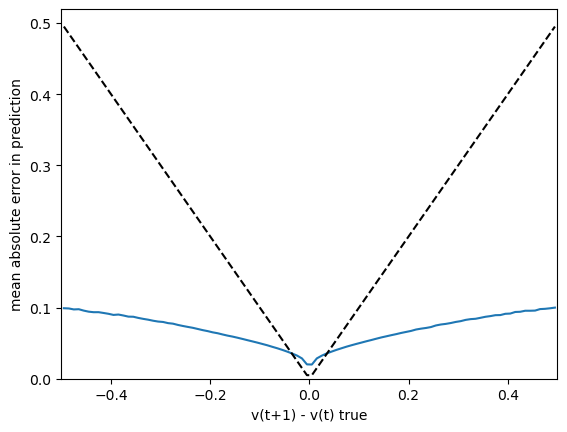

In [304]:

plt.plot(mps, num / den)
plt.plot(mps, np.abs(mps), color="k", ls="dashed")
plt.xlabel("v(t+1) - v(t) true")
plt.xlim(-0.5, 0.5)
plt.ylim(0, None)
plt.ylabel("mean absolute error in prediction")
